In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
#値を-1から1に正規化する関数
def normalize_x(image):
    return image / 127.5 - 1


def denormalize_x(image):
    return (image + 1) * 127.5


#値を0から1正規化する関数
def normalize_y(image):
    return image / 255


#値を0から255に戻す関数
def denormalize_y(image):
    return image * 255

In [3]:
# インプット画像を読み込む関数
def load_X_gray(folder_path):
    
    image_files = []

    #image_files = os.listdir(folder_path)
       
    for file in os.listdir(folder_path):
        base, ext = os.path.splitext(file)
        if ext == '.png':
            image_files.append(file)
        else :
            pass
        
    image_files.sort()
    
    img = cv2.imread(folder_path + os.sep + image_files[0], cv2.IMREAD_GRAYSCALE)
    
    #image_files = image_files[1:]
    images = np.zeros((len(image_files), img.shape[0], img.shape[1], 1), np.float32)
    for i, image_file in tqdm(enumerate(image_files)):
        image = cv2.imread(folder_path + os.sep + image_file, cv2.IMREAD_GRAYSCALE)
        #image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image[:, :, np.newaxis]
        images[i] = normalize_x(image)
    
    return images, image_files


def load_Y_gray(folder_path, thresh = None , normalize = True, g_size = None):
    image_files = []
    #image_files = os.listdir(folder_path)
    
    for file in os.listdir(folder_path):
        base, ext = os.path.splitext(file)
        if ext == '.png':
            image_files.append(file)
        else:
            pass
        
    image_files.sort()
    
    img = cv2.imread(folder_path + os.sep + image_files[0], cv2.IMREAD_GRAYSCALE)
    
    images = np.zeros(
        (len(image_files), img.shape[0], img.shape[1], 1) ,np.float32
    )
    
    for i , image_file in tqdm(enumerate(image_files)):
        image = cv2.imread(
            folder_path + os.sep + image_file ,
            cv2.IMREAD_GRAYSCALE
        )
        #print(image.shape)
        
        # ぼかし処理
        if g_size:
            image = cv2.GaussianBlur(
                image, (g_size, g_size), 0
            )        
        
        if thresh:
            ret , image = cv2.threshold(image , thresh , 255 , cv2.THRESH_BINARY)
        image = image[ : , : , np.newaxis]
        if normalize:
            images[i] = normalize_y(image)
        else:
            images[i] = image
    
    return images , image_files

In [4]:
def make_mask_img(ori_img, mask_img):
    mask_img_rgb = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), np.float32)
    mask_img_rgb[:,:,0] = mask_img[:,:,0]
    mask_img_rgb[:,:,2] = mask_img[:,:,0]
    masked_img = cv2.addWeighted(mask_img_rgb,0.5,cv2.cvtColor(ori_img+0.75, cv2.COLOR_GRAY2BGR),0.6,0)
    return masked_img


def make_two_mask_img(ori_img, mask_img, raw_img):
    mask_img_rgb = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), np.float32)
    mask_img_rgb[:,:,2] = mask_img[:,:,0]
    mask_img_rgb[:,:,0] = mask_img[:,:,0]
    mask_img_rgb[:,:,1] += np.where(
        (raw_img[:,:,0]* 255 < 170) & (raw_img[:,:,0]* 255 > 127),
        1,
        0
    )
    mask_img_rgb[:,:,2] -= mask_img_rgb[:,:,1]
    mask_img_rgb[:,:,0] -= mask_img_rgb[:,:,1]
    
    masked_img = cv2.addWeighted(mask_img_rgb,0.5,cv2.cvtColor(ori_img+0.75, cv2.COLOR_GRAY2BGR),0.6,0)
    return masked_img

In [5]:
def culc_F1(pred, gt):
    
    PRE = np.count_nonzero((pred*255 > 0.5) & (gt* 255 > 0.5)) / np.count_nonzero(pred*255 > 0.5)
    RE = np.count_nonzero((pred*255 > 0.5) & (gt * 255 > 0.5)) / np.count_nonzero(gt*255 > 0.5)
    
    try:
        F1 = 2 * (PRE * RE) / (PRE + RE)
        print(f"Precision: {round(PRE,2)}, Recall: {round(RE,2)}, F1: {round(F1,2)} ")
        print(f"Precision: {PRE}, Recall: {RE}, F1: {F1} ")
        return F1
    except ZeroDivisionError:
        return 0
    except:
        return "error"

In [6]:
ori_80_imgs , _ = load_X_gray('I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002/original//')

pred_imgs_001, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_002/merged_001/", normalize=False)
pred_imgs_002, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_002/merged_002/", normalize=False)
pred_imgs_003, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_002/merged_003/", normalize=False)

ori_imgs, _ = load_X_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/dataset/cropped_002/resize_10x10x10/")
wo_pred_imgs, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_without_HITL/merged_001/", normalize=False)
mito_imgs, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/annotations/cropped_002/devided_mito__/", normalize=False)

pred_imgs_001_raw, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_002/merged_001_raw//", normalize=False)
pred_imgs_002_raw, _ = load_Y_gray("I:/DeepLearningData/research_010_NIH3T3/shCtrl_001_realignment/active_learning_dataset/cropped_002_002/merged_002_raw//", normalize=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# (i)

In [7]:
N = 54
y = 850
x =  300
N_ = N +30
y_ = y + 143
x_ = x + 120

ori = ori_80_imgs[N][y:y+150, x:x+150]
pred_001 = pred_imgs_001[N][y:y+150, x:x+150]
pred_002 = pred_imgs_002[N][y:y+150, x:x+150]
pred_003 = pred_imgs_003[N][y:y+150, x:x+150]
pred_wo = wo_pred_imgs[N][y:y+150, x:x+150]
mito = mito_imgs[N_][y_:y_+150, x_:x_+150]
pred_001_raw = pred_imgs_001_raw[N][y:y+150, x:x+150] / 255

masked_ori_img = make_mask_img(ori, np.zeros_like(ori))
masked_first_pred_img = make_two_mask_img(ori, pred_001, pred_001_raw)
masked_second_pred_img = make_mask_img(ori, pred_002)
masked_third_pred_img = make_mask_img(ori, pred_003)
masked_woHITL_pred_img = make_mask_img(ori, pred_wo)
masked_gt_img = make_mask_img(ori, mito)

print("1st pred")
pred_f1_matrix = culc_F1(pred_001, mito)

print("2nd pred")
pred_f1_matrix = culc_F1(pred_002, mito)

print("3rd pred")
pred_f1_matrix = culc_F1(pred_003, mito)

print("wo pred")
pred_f1_matrix = culc_F1(pred_wo, mito)

1st pred
Precision: 1.0, Recall: 0.8, F1: 0.89 
Precision: 0.9985363753766681, Recall: 0.7969490826633684, F1: 0.8864261693671661 
2nd pred
Precision: 1.0, Recall: 0.99, F1: 0.99 
Precision: 0.9973689676659974, Recall: 0.9898302755445613, F1: 0.9935853221133949 
3rd pred
Precision: 1.0, Recall: 0.99, F1: 1.0 
Precision: 0.9993077189338871, Recall: 0.9918917061774205, F1: 0.9955859024760328 
wo pred
Precision: 1.0, Recall: 0.78, F1: 0.87 
Precision: 0.9956972251492799, Recall: 0.7791520648663506, F1: 0.8742145638178945 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


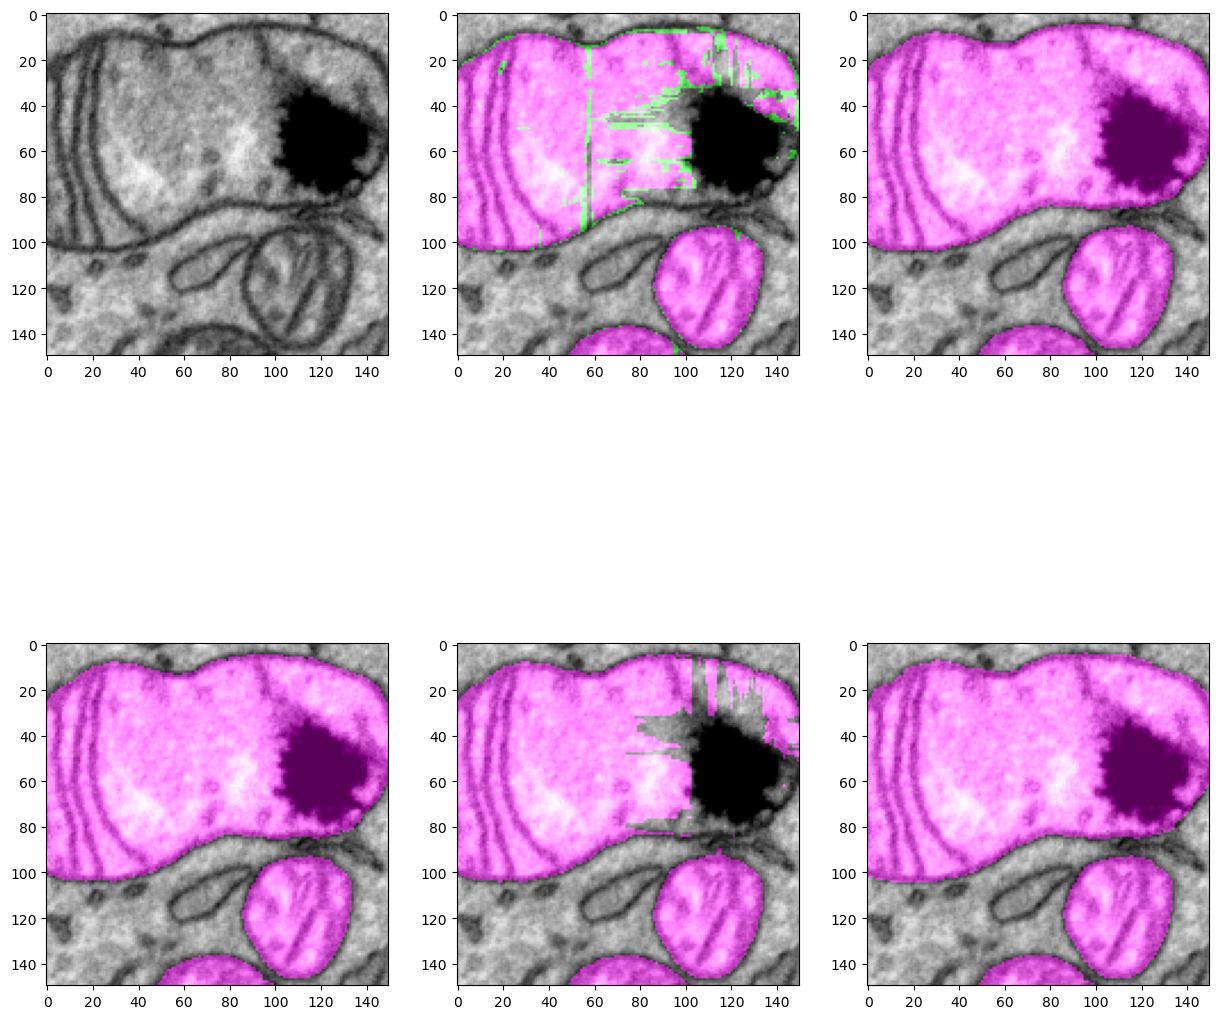

In [8]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(masked_ori_img)

plt.subplot(2, 3, 2)
plt.imshow(masked_first_pred_img)

plt.subplot(2, 3, 3)
plt.imshow(masked_second_pred_img)

plt.subplot(2, 3, 4)
plt.imshow(masked_third_pred_img)

plt.subplot(2, 3, 5)
plt.imshow(masked_woHITL_pred_img)

plt.subplot(2, 3, 6)
plt.imshow(masked_gt_img)

In [9]:
out_dir = "Z:/paper_data/2021_cristae/for_revision_#2/fig3B/slice#1"
os.makedirs(out_dir, exist_ok=True)

cv2.imwrite(os.path.join(out_dir, "raw_image.png"), denormalize_y(masked_ori_img))
cv2.imwrite(os.path.join(out_dir, "1st_pred.png"), denormalize_y(masked_first_pred_img))
cv2.imwrite(os.path.join(out_dir, "2nd_pred.png"), denormalize_y(masked_second_pred_img))
cv2.imwrite(os.path.join(out_dir, "3rd_pred.png"), denormalize_y(masked_third_pred_img))
cv2.imwrite(os.path.join(out_dir, "wo_HITL.png"), denormalize_y(masked_woHITL_pred_img))
cv2.imwrite(os.path.join(out_dir, "gt.png"), denormalize_y(masked_gt_img))


True

# (ii)

In [10]:
N = 92
y = 800
x =  350
N_ = N +30
y_ = y + 143
x_ = x + 120

ori = ori_80_imgs[N][y:y+150, x:x+150]
pred_001 = pred_imgs_001[N][y:y+150, x:x+150]
pred_002 = pred_imgs_002[N][y:y+150, x:x+150]
pred_003 = pred_imgs_003[N][y:y+150, x:x+150]
pred_wo = wo_pred_imgs[N][y:y+150, x:x+150]
mito = mito_imgs[N_][y_:y_+150, x_:x_+150]
pred_002_raw = pred_imgs_002_raw[N][y:y+150, x:x+150] / 255

masked_ori_img = make_mask_img(ori, np.zeros_like(ori))
masked_first_pred_img = make_mask_img(ori, pred_001)
masked_second_pred_img = make_two_mask_img(ori, pred_002, pred_002_raw)
masked_third_pred_img = make_mask_img(ori, pred_003)
masked_woHITL_pred_img = make_mask_img(ori, pred_wo)
masked_gt_img = make_mask_img(ori, mito)

print("1st pred")
pred_f1_matrix = culc_F1(pred_001, mito)

print("2nd pred")
pred_f1_matrix = culc_F1(pred_002, mito)

print("3rd pred")
pred_f1_matrix = culc_F1(pred_003, mito)

print("wo pred")
pred_f1_matrix = culc_F1(pred_wo, mito)

1st pred
Precision: 0.99, Recall: 0.91, F1: 0.95 
Precision: 0.9938521909744932, Recall: 0.911249700167906, F1: 0.9507601826941126 
2nd pred
Precision: 0.98, Recall: 0.96, F1: 0.97 
Precision: 0.9762889105058365, Recall: 0.9629407531782201, F1: 0.9695688926458157 
3rd pred
Precision: 0.99, Recall: 0.96, F1: 0.98 
Precision: 0.990491479377624, Recall: 0.9619812904773327, F1: 0.9760282307130689 
wo pred
Precision: 0.99, Recall: 0.95, F1: 0.97 
Precision: 0.9908440988335633, Recall: 0.9474694171264092, F1: 0.9686714487155907 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


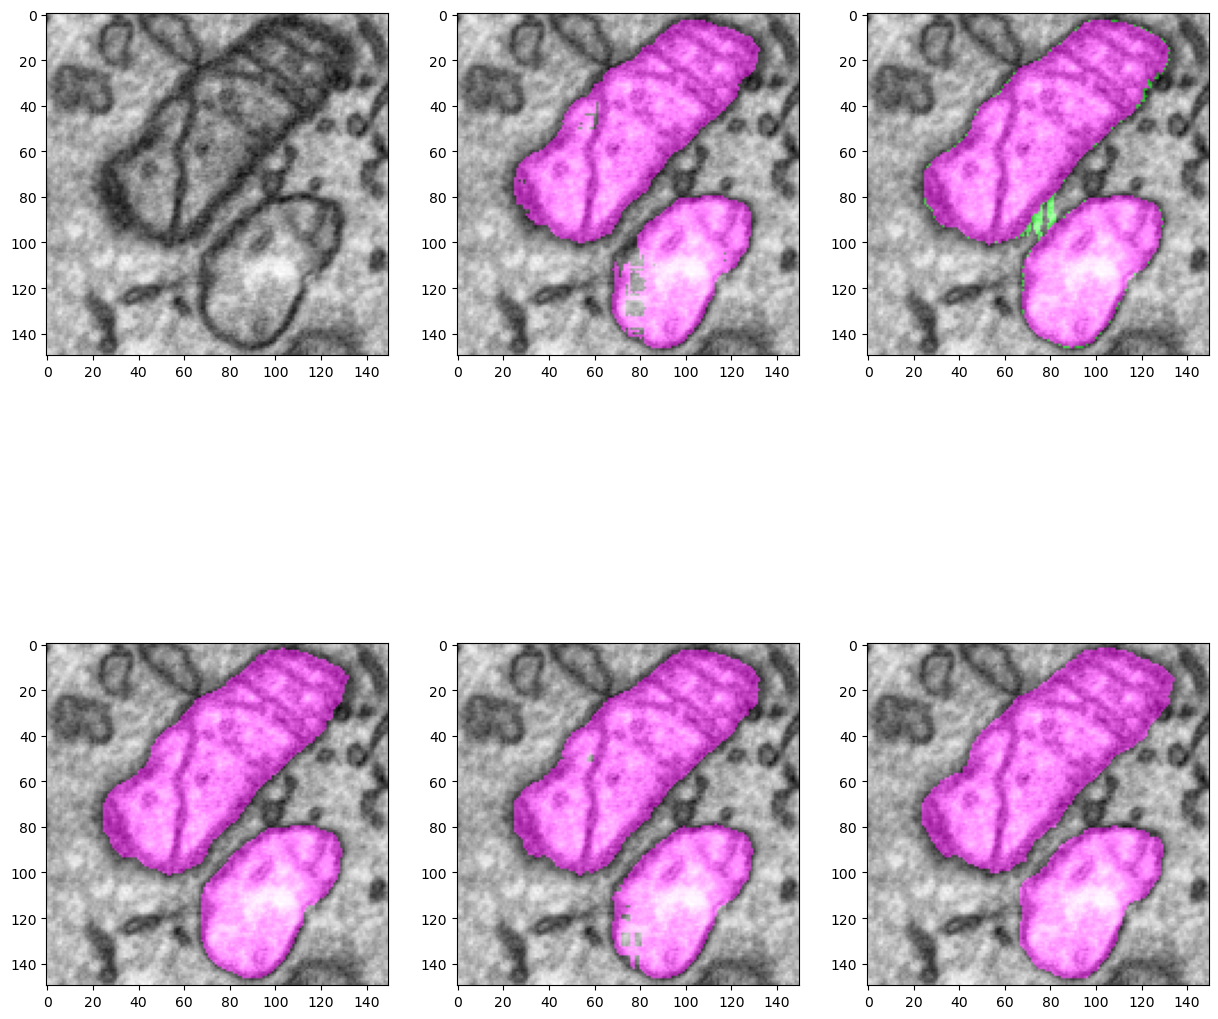

In [11]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(masked_ori_img)

plt.subplot(2, 3, 2)
plt.imshow(masked_first_pred_img)

plt.subplot(2, 3, 3)
plt.imshow(masked_second_pred_img)

plt.subplot(2, 3, 4)
plt.imshow(masked_third_pred_img)

plt.subplot(2, 3, 5)
plt.imshow(masked_woHITL_pred_img)

plt.subplot(2, 3, 6)
plt.imshow(masked_gt_img)

In [12]:
out_dir = "Z:/paper_data/2021_cristae/for_revision_#2/fig3B/slice#2"
os.makedirs(out_dir, exist_ok=True)

cv2.imwrite(os.path.join(out_dir, "raw_image.png"), denormalize_y(masked_ori_img))
cv2.imwrite(os.path.join(out_dir, "1st_pred.png"), denormalize_y(masked_first_pred_img))
cv2.imwrite(os.path.join(out_dir, "2nd_pred.png"), denormalize_y(masked_second_pred_img))
cv2.imwrite(os.path.join(out_dir, "3rd_pred.png"), denormalize_y(masked_third_pred_img))
cv2.imwrite(os.path.join(out_dir, "wo_HITL.png"), denormalize_y(masked_woHITL_pred_img))
cv2.imwrite(os.path.join(out_dir, "gt.png"), denormalize_y(masked_gt_img))


True

# (iii)

In [13]:
N = 70
y = 825
x =  320
N_ = N +30
y_ = y + 143
x_ = x + 120

ori = ori_80_imgs[N][y:y+150, x:x+150]
pred_001 = pred_imgs_001[N][y:y+150, x:x+150]
pred_002 = pred_imgs_002[N][y:y+150, x:x+150]
pred_003 = pred_imgs_003[N][y:y+150, x:x+150]
pred_wo = wo_pred_imgs[N][y:y+150, x:x+150]
mito = mito_imgs[N_][y_:y_+150, x_:x_+150]

masked_ori_img = make_mask_img(ori, np.zeros_like(ori))
masked_first_pred_img = make_mask_img(ori, pred_001)
masked_second_pred_img = make_mask_img(ori, pred_002)
masked_third_pred_img = make_mask_img(ori, pred_003)
masked_woHITL_pred_img = make_mask_img(ori, pred_wo)
masked_gt_img = make_mask_img(ori, mito)

print("1st pred")
pred_f1_matrix = culc_F1(pred_001, mito)

print("2nd pred")
pred_f1_matrix = culc_F1(pred_002, mito)

print("3rd pred")
pred_f1_matrix = culc_F1(pred_003, mito)

print("wo pred")
pred_f1_matrix = culc_F1(pred_wo, mito)

1st pred
Precision: 0.99, Recall: 0.67, F1: 0.8 
Precision: 0.9866818873668188, Recall: 0.6706323548428812, F1: 0.7985218261605974 
2nd pred
Precision: 0.99, Recall: 0.98, F1: 0.98 
Precision: 0.9865658014868919, Recall: 0.9781456097245571, F1: 0.9823376623376624 
3rd pred
Precision: 0.99, Recall: 0.98, F1: 0.98 
Precision: 0.9876108502869066, Recall: 0.9793094529936636, F1: 0.9834426335952211 
wo pred
Precision: 0.99, Recall: 0.68, F1: 0.81 
Precision: 0.9891345073061072, Recall: 0.6827880512091038, F1: 0.807895340830847 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


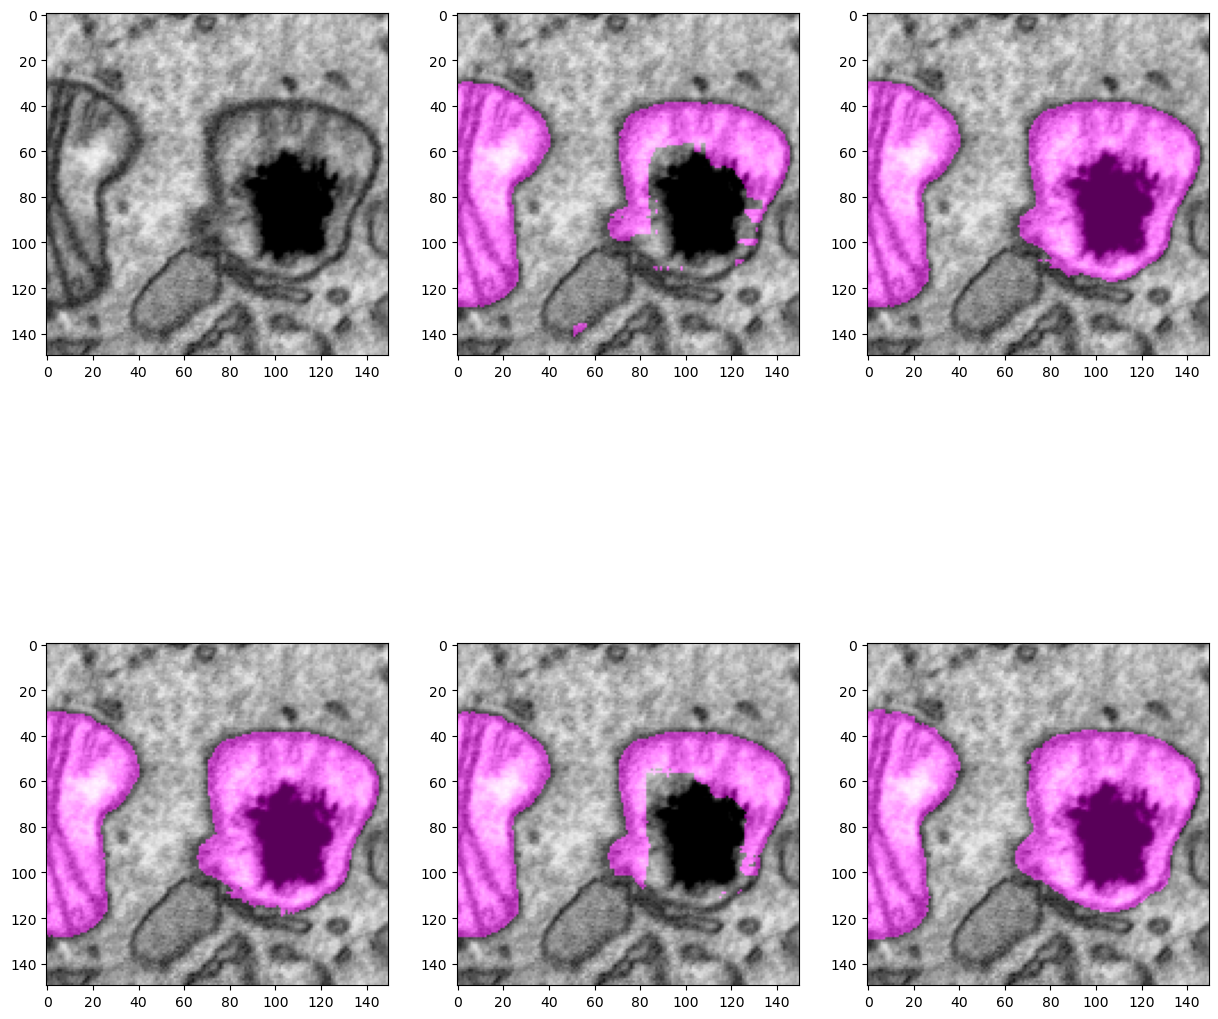

In [14]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(masked_ori_img)

plt.subplot(2, 3, 2)
plt.imshow(masked_first_pred_img)

plt.subplot(2, 3, 3)
plt.imshow(masked_second_pred_img)

plt.subplot(2, 3, 4)
plt.imshow(masked_third_pred_img)

plt.subplot(2, 3, 5)
plt.imshow(masked_woHITL_pred_img)

plt.subplot(2, 3, 6)
plt.imshow(masked_gt_img)

In [15]:
out_dir = "Z:/paper_data/2021_cristae/for_revision_#2/fig3B/slice#3"
os.makedirs(out_dir, exist_ok=True)

cv2.imwrite(os.path.join(out_dir, "raw_image.png"), denormalize_y(masked_ori_img))
cv2.imwrite(os.path.join(out_dir, "1st_pred.png"), denormalize_y(masked_first_pred_img))
cv2.imwrite(os.path.join(out_dir, "2nd_pred.png"), denormalize_y(masked_second_pred_img))
cv2.imwrite(os.path.join(out_dir, "3rd_pred.png"), denormalize_y(masked_third_pred_img))
cv2.imwrite(os.path.join(out_dir, "wo_HITL.png"), denormalize_y(masked_woHITL_pred_img))
cv2.imwrite(os.path.join(out_dir, "gt.png"), denormalize_y(masked_gt_img))


True

# (iv)

In [16]:
N = 42
y = 850
x =  300
N_ = N +30
y_ = y + 143
x_ = x + 120

ori = ori_80_imgs[N][y:y+150, x:x+150]
pred_001 = pred_imgs_001[N][y:y+150, x:x+150]
pred_002 = pred_imgs_002[N][y:y+150, x:x+150]
pred_003 = pred_imgs_003[N][y:y+150, x:x+150]
pred_wo = wo_pred_imgs[N][y:y+150, x:x+150]
mito = mito_imgs[N_][y_:y_+150, x_:x_+150]

masked_ori_img = make_mask_img(ori, np.zeros_like(ori))
masked_first_pred_img = make_mask_img(ori, pred_001)
masked_second_pred_img = make_mask_img(ori, pred_002)
masked_third_pred_img = make_mask_img(ori, pred_003)
masked_woHITL_pred_img = make_mask_img(ori, pred_wo)
masked_gt_img = make_mask_img(ori, mito)

print("1st pred")
pred_f1_matrix = culc_F1(pred_001, mito)

print("2nd pred")
pred_f1_matrix = culc_F1(pred_002, mito)

print("3rd pred")
pred_f1_matrix = culc_F1(pred_003, mito)

print("wo pred")
pred_f1_matrix = culc_F1(pred_wo, mito)

1st pred
Precision: 1.0, Recall: 0.95, F1: 0.97 
Precision: 0.9953562850280224, Recall: 0.9456149691944931, F1: 0.96984826617779 
2nd pred
Precision: 1.0, Recall: 0.99, F1: 0.99 
Precision: 0.9950984146434863, Recall: 0.9882863010572754, F1: 0.9916806594413066 
3rd pred
Precision: 1.0, Recall: 0.99, F1: 0.99 
Precision: 0.9973136848568578, Recall: 0.988362364037423, F1: 0.9928178484107579 
wo pred
Precision: 0.99, Recall: 0.93, F1: 0.96 
Precision: 0.9921215074723847, Recall: 0.929109302502472, F1: 0.959582073137201 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


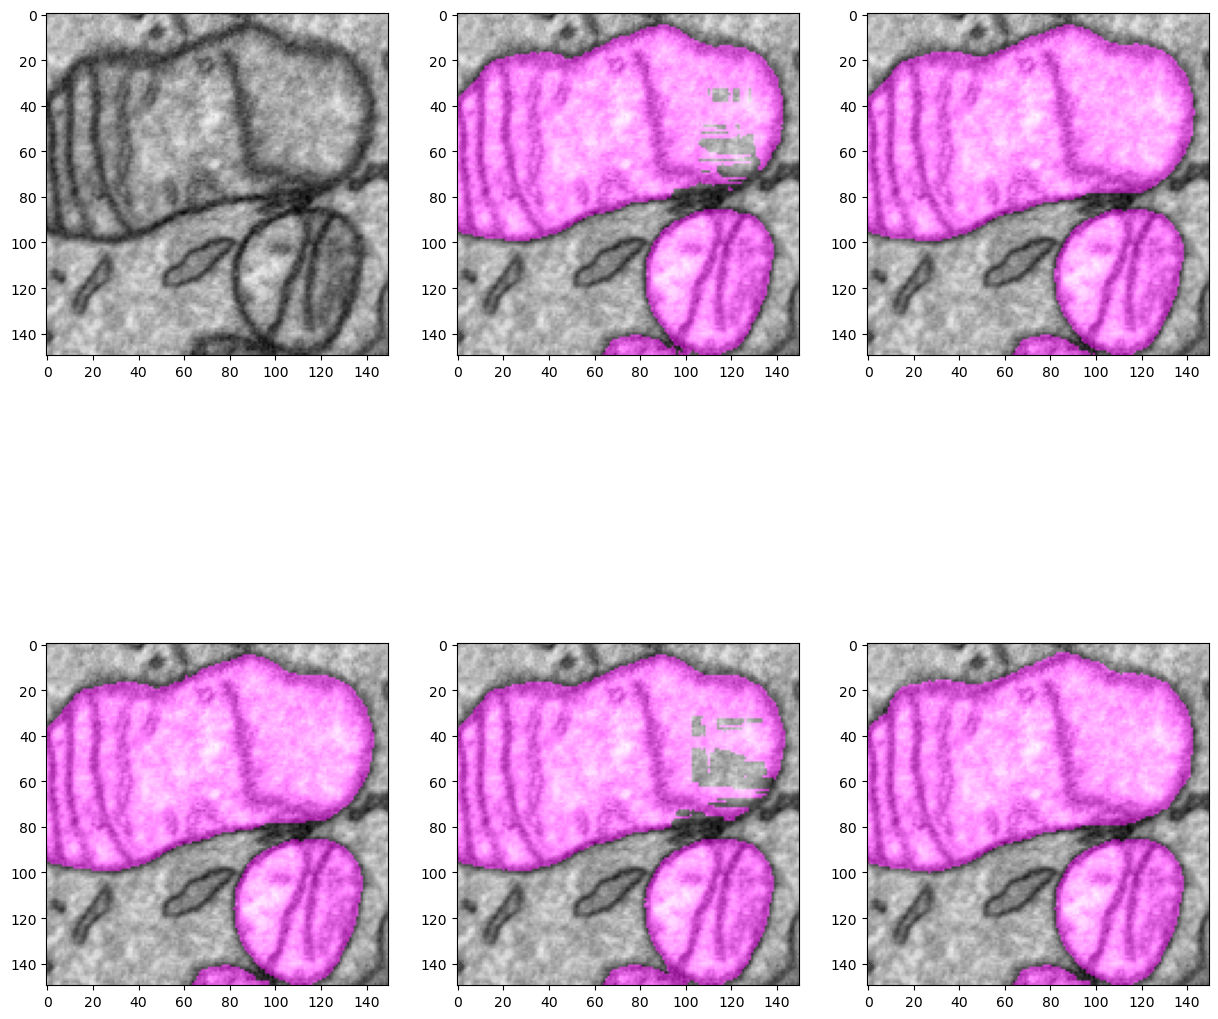

In [17]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(masked_ori_img)

plt.subplot(2, 3, 2)
plt.imshow(masked_first_pred_img)

plt.subplot(2, 3, 3)
plt.imshow(masked_second_pred_img)

plt.subplot(2, 3, 4)
plt.imshow(masked_third_pred_img)

plt.subplot(2, 3, 5)
plt.imshow(masked_woHITL_pred_img)

plt.subplot(2, 3, 6)
plt.imshow(masked_gt_img)

In [18]:
out_dir = "Z:/paper_data/2021_cristae/for_revision_#2/fig3B/slice#4"
os.makedirs(out_dir, exist_ok=True)

cv2.imwrite(os.path.join(out_dir, "raw_image.png"), denormalize_y(masked_ori_img))
cv2.imwrite(os.path.join(out_dir, "1st_pred.png"), denormalize_y(masked_first_pred_img))
cv2.imwrite(os.path.join(out_dir, "2nd_pred.png"), denormalize_y(masked_second_pred_img))
cv2.imwrite(os.path.join(out_dir, "3rd_pred.png"), denormalize_y(masked_third_pred_img))
cv2.imwrite(os.path.join(out_dir, "wo_HITL.png"), denormalize_y(masked_woHITL_pred_img))
cv2.imwrite(os.path.join(out_dir, "gt.png"), denormalize_y(masked_gt_img))


True